# SciPy Retrieval Performance Analysis

Comprehensive analysis of sparse (BM25) and dense (FAISS) retrieval performance including:
- Per-chunk loading time analysis
- Scalability characteristics
- Query runtime comparison
- Retrieval analysis


## Setup and Installation


In [ ]:
# Install required packages
%pip install sentence-transformers langchain-core langchain-community langchain-text-splitters
%pip install langchain-huggingface faiss-cpu rank_bm25 pypdf numpy nltk matplotlib


In [2]:
import glob
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# Setup for Google Colab (remove if running locally)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/SciPy')
except ImportError:
    pass

from Modules.scipy_retriever_helper import ScipyRetrieverHelper


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configuration and Data Loading


In [3]:
# Configuration
NUM_DOCUMENTS = 20
CHUNK_SIZE = 2000
CHUNK_OVERLAP = 100

print(f"Configuration:")
print(f"   Documents: {NUM_DOCUMENTS}")
print(f"   Chunk size: {CHUNK_SIZE}")
print(f"   Overlap: {CHUNK_OVERLAP}")


Configuration:
   Documents: 20
   Chunk size: 2000
   Overlap: 100


In [4]:
# Load documents
folder_path = 'Data/selected_files_scipy'
txt_files = glob.glob(os.path.join(folder_path, '*.txt'))[:NUM_DOCUMENTS]
print(f"Found {len(txt_files)} text files")

documents_dict = {}
for fp in txt_files:
    try:
        with open(fp, 'r', encoding='utf-8') as f:
            documents_dict[os.path.basename(fp)] = f.read()
    except Exception as e:
        print(f"Error reading {fp}: {e}")

print(f"Successfully loaded {len(documents_dict)} documents")


Found 20 text files
Successfully loaded 20 documents


In [5]:
# Create chunks
docs = [
    Document(page_content=content, metadata={"source": filename})
    for filename, content in documents_dict.items()
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
)
texts = text_splitter.split_documents(docs)

chunks = []
for i, text in enumerate(texts):
    chunk_dict = {
        "content": text.page_content,
        "metadata": {
            **text.metadata,
            "chunk_id": i
        }
    }
    chunks.append(chunk_dict)

print(f"Created {len(chunks)} chunks from {len(docs)} documents")
print(f"Average chunks per document: {len(chunks)/len(docs):.1f}")


Created 520 chunks from 20 documents
Average chunks per document: 26.0


## Retriever Initialization and Performance Analysis


In [6]:
# Initialize retriever and add documents
retriever = ScipyRetrieverHelper()
retriever.add_documents(chunks)

# Initialize sparse retriever with timing analysis
sparse_stats = retriever.analyze_sparse_incremental_cost(return_stats=True)

BM25 Incremental Analysis: 100%|██████████| 520/520 [00:14<00:00, 36.84docs/s]


In [7]:
# Initialize dense retriever with timing analysis
dense_stats = retriever.analyze_dense_incremental_cost(return_stats=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

FAISS Incremental Analysis: 100%|██████████| 520/520 [06:57<00:00,  1.25docs/s]


## Chunk Loading Time Visualization


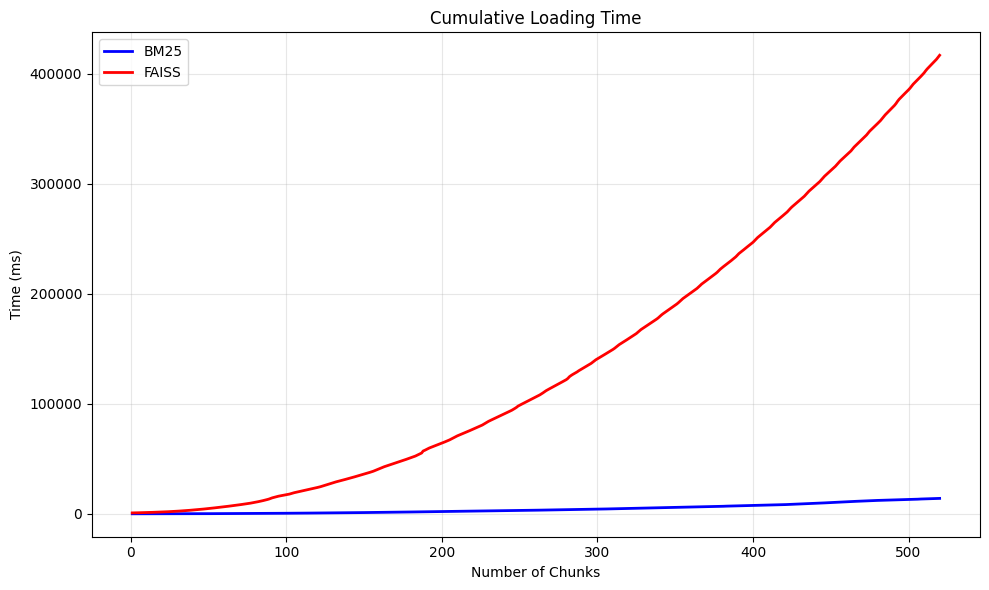

In [8]:
# Visualize chunk loading times
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

chunk_numbers = list(range(1, len(sparse_stats['chunk_times']) + 1))

# Cumulative time comparison
sparse_cumulative = np.cumsum(sparse_stats['chunk_times'])
dense_cumulative = np.cumsum(dense_stats['chunk_times'])

ax.plot(chunk_numbers, sparse_cumulative, 'b-', linewidth=2, label='BM25')
ax.plot(chunk_numbers, dense_cumulative, 'r-', linewidth=2, label='FAISS')
ax.set_xlabel('Number of Chunks')
ax.set_ylabel('Time (ms)')
ax.set_title('Cumulative Loading Time')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Query Runtime and Overlap Analysis


In [10]:
# Test queries for runtime analysis
test_queries = [
    "What is Machine Learning?"
]

query_results = []

print("Query Runtime Analysis with Top 3 Results:")
print("=" * 80)

for query in test_queries:
    print(f"\nQuery: '{query}'")
    print("-" * 60)

    # Get sparse results
    sparse_docs, sparse_time = retriever.retrieve_sparse(query, top_k=3)

    # Get dense results
    dense_docs, dense_time = retriever.retrieve_dense(query, top_k=3)

    query_results.append({
        'query': query,
        'sparse_time': sparse_time,
        'dense_time': dense_time,
        'sparse_docs': sparse_docs,
        'dense_docs': dense_docs
    })

    print(f"Timing: Sparse {sparse_time:.2f}ms | Dense {dense_time:.2f}ms")
    print()

    # Display Sparse Results
    print("SPARSE (BM25) - Top 3 Results:")
    for i, doc in enumerate(sparse_docs, 1):
        content_preview = doc.page_content[:150] + "..." if len(doc.page_content) > 150 else doc.page_content
        source = doc.metadata.get('source', 'Unknown')
        chunk_id = doc.metadata.get('chunk_id', 'N/A')

        print(f"  {i}. Source: {source} | Chunk ID: {chunk_id}")
        print(f"     Content: {content_preview}")
        print()

    # Display Dense Results
    print("DENSE (FAISS) - Top 3 Results:")
    for i, doc in enumerate(dense_docs, 1):
        content_preview = doc.page_content[:150] + "..." if len(doc.page_content) > 150 else doc.page_content
        source = doc.metadata.get('source', 'Unknown')
        chunk_id = doc.metadata.get('chunk_id', 'N/A')

        print(f"  {i}. Source: {source} | Chunk ID: {chunk_id}")
        print(f"     Content: {content_preview}")
        print()

    print("=" * 80)

Query Runtime Analysis with Top 3 Results:

Query: 'What is Machine Learning?'
------------------------------------------------------------
Timing: Sparse 2.29ms | Dense 9.70ms

SPARSE (BM25) - Top 3 Results:
  1. Source: 2311.11911v1.txt | Chunk ID: 397
     Content: There is a growing concern about the potential of machine learning models to perpetuate and amplify discrimination (Barocas & Selbst, 2016). Machine l...

  2. Source: 2311.18825v1.txt | Chunk ID: 47
     Content: In this section, we present the experimental results that answer the following research questions: (1)Do existing methods show a balanced spatio-tempo...

  3. Source: 2311.06152v1.txt | Chunk ID: 278
     Content: Topological data analysis (TDA) is a rapidly growing field that provides tools from algebraic topology for uncovering the shape (or structure) of data...

DENSE (FAISS) - Top 3 Results:
  1. Source: 2311.01106v1.txt | Chunk ID: 324
     Content: As machine learning models get deployed in risk-critical